## Possible DarkQuest acceptance

Simple contour plots showing reach of darkquest detection of A'-> dileptons.
Depends on rates files in `data` directory.

In [1]:
import math
import numpy
import os
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
import random as rand
from collections import OrderedDict 

Parse input file.
Takes as input log file from running over available mass/coupling parameter space with the following format:

```line format: n_accepted total_events mass eps min_vz max_vz Brem/Eta```

In [2]:
class event:
    def __init__(self,values):
        self._acpE = int(values[0])
        self._nEv = int(values[1])
        self._mass = float(values[2])
        self._eps = float(values[3])
        self._minvz = float(values[4])
        self._maxvz = float(values[5])
        self._mech = str(values[6])
        
    def getRatio(self):
        return(self._acpE/self._nEv)
    
    def getEps(self):
        return self._eps
    
    def getMass(self):
        return self._mass
    
    def getMech(self):
        return self._mech
    
    def __repr__(self):
        return str([self._acpE,self._nEv,self._mass,self._eps,self._minvz,self._maxvz,self._mech])
    
def parseFile(minVz,maxVz,lep="muons",mech="Brem"):
    #line format: n_accepted total_events mass eps min_vz max_vz Brem/Eta 
    fileName = "data/output_%s_%i_%i.txt"%(lep,minVz,maxVz)
    #fileName = "data/output_%s_%i_%i_v2.txt"%(lep,minVz,maxVz)
    file = open(fileName)
    prevLine = ""
    spStr = ""
    eventsList = []
    for l in file.readlines():
        spStr = l.split()
        newEvent = event(spStr)
        if newEvent.getMech()==mech:
            eventsList.append(newEvent)
    return eventsList


The following are functions that read rates/BR files

In [3]:
# rates: xs *BR
# assume that BR e- ~= BR muons for now
# unless Asher can give us similar files for e-
def getRate(lep="muons",mech="Brem"):
    rates = OrderedDict() 
    ifile = open("data/AprimeToMuonsRate_%s.txt"%mech)
    for l in ifile:
        temp = l.split()
        if 'GeV' in l: continue
        rates['%.3f'%float(temp[0])] = float(temp[1])
    return rates

def getRatefromAsher(epsilon,POT,lep="muons",mech="Brem"):
    bfs = {}
    if lep=='muons':
        iBFfile = "data/BFtoMuons.txt"
    else:
        iBFfile = "data/BFtoElectrons.txt"
    iBR = open(iBFfile)
    #Log[10,mAp/GeV]	Log[10,BF]
    for l in iBR:
        temp = l.split()
        if '#' in l or len(temp)==0: continue
        mass = pow(10,float(temp[0]))
        bfs['%.3f'%mass] = pow(10,float(temp[1]))

    rates = OrderedDict() 
    ifileYield = open("data/%sYield.txt"%mech)
    #epsilon = 10^-6, POT = 1.44*10^18, rescale yield as NAp = column2*(epsilon/10^-6)^2 (POT/1.44*10^18)
    #Log[10,mAp/GeV]	Log[10,NAp]
    for l in ifileYield:
        temp = l.split()
        if '#' in l or len(temp)==0: continue
        mass = pow(10,float(temp[0]))
        column2 = pow(10,float(temp[1]))
        NAp = column2*(POT/1.44e18)*(epsilon/10**(-6))**2
        if '%.3f'%mass in bfs:
            BF = bfs['%.3f'%mass]
        else:
            print('No BF!')
            BF = 1
        rates['%.3f'%mass] = NAp*BF
    return rates

# this function interpolates between existent rates
def addrates(masses,rates):
    im = 0
    lrates = list(rates.values())
    new_rates = {}
    for m in masses:
        mass = '%.3f'%m
        if mass in list(rates.keys()):
            im = im + 1
            new_rates[mass] = rates[mass]
        else:
            new_rates[mass] = lrates[im-1]
    return new_rates

In [4]:
def yields(minVz,maxVz,lep="muons",mech="Brem"):
    events = parseFile(minVz,maxVz,lep)
    
    # protons on target
    #POT = 10**18 
    POT = 1.44e18
    
    yields = {}
    masses = []
    epsilons = []
    couplings = {}
        
    for ev in events:
        if ev.getMass() not in masses:
            masses.append(ev.getMass())
        if ev.getEps() not in epsilons:
            epsilons.append(ev.getEps())
        if ev.getEps() in couplings:
            couplings[ev.getEps()].append(ev)
        else:
            couplings[ev.getEps()]=[ev]

    cross = []
    i=0
    rates_per_eps = {}
    ratios_per_eps = {}
    for eps in epsilons:
        old_rates = getRate(lep,mech)
        rates = getRatefromAsher(eps,POT,lep,mech)
        new_rates = addrates(masses,rates)
        rates_per_eps['%.2e'%eps] = rates
        ratios_per_eps['%.2e'%eps] = {}
        cross.append([])
        for m in masses:
            for ev in events:
                if ev.getMass() == m and ev.getEps() == eps:
                    cross[i].append(ev.getRatio()*new_rates['%.3f'%m]) #*POT*eps**2) # this is not needed anymore since its accounted for in the new_rates
                    ratios_per_eps['%.2e'%eps]['%.3f'%m] = ev.getRatio()
        i+=1
        
    # now plot
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    CS = ax.contour(masses, epsilons, cross,levels=1000,cmap = "viridis")
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(r'Acceptance*POT*$\epsilon^{2}$*XS*BR %s %i %i'%(mech,minVz,maxVz))
    ax.set_yscale('log')
    if lep=='muons':
        if 'Brem' in mech:
            ax.set_xlim(.25,3.05)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.25,.55)
    if lep=='electrons':
        ax.set_ylim(1e-8,1e-2)
        if 'Brem' in mech:
            ax.set_xlim(.01,3.05)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.01,1.5) 
            ax.set_xscale('log')
    plt.colorbar(CS)
    plt.show()
    #plt.savefig("yield_%s_%s.png"%(lep,mech))
    plt.clf()
    
    # now plot 10 ev contour
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    CS = ax.contour(masses, epsilons, cross,levels=[10],cmap = "viridis")
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(r'Acceptance*POT*$\epsilon^{2}$*XS*BR %s %i %i 10ev'%(mech,minVz,maxVz))
    ax.set_yscale('log')
    if lep=='muons':
        if 'Brem' in mech:
            ax.set_xlim(.25,3.05)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.25,.55)
    if lep=='electrons':
        ax.set_ylim(1e-8,1e-2)
        if 'Brem' in mech:
            ax.set_xlim(.01,3.05)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.01,3.05) 
            ax.set_xscale('log')
    plt.show()
    #plt.savefig("yield_%s_%s_10ev.png"%(lep,mech))
    plt.clf()
    
    # now plot rates
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    masses = [float(i) for i in rates_per_eps['%.2e'%(1e-06)].keys()]
    naps = list(rates_per_eps['%.2e'%(1e-06)].values())
    plt.plot(masses,naps,color='blue')
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$N_A^{'}$")
    ax.set_xlim(.01,1.5) 
    ax.set_ylim(1,1e7)
    ax.set_xscale('log')
    ax.set_title(r'$E_{beam}=$120 GeV,POT=1.44e18,$\epsilon=10^{-6}$ %s'%(mech))
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()
    #plt.savefig("nap_eps1em6_%s_%s.png"%(lep,mech))
    plt.clf()
    
    # now plot acceptance only
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    masses = [float(i) for i in ratios_per_eps['%.2e'%(1e-06)].keys()]
    naps = list(ratios_per_eps['%.2e'%(1e-06)].values())
    plt.plot(masses,naps,color='green')
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"Acceptance")
    ax.set_xlim(.01,1.5) 
    ax.set_ylim(0.01,1)
    ax.set_xscale('log')
    ax.set_title(r'$E_{beam}=$120 GeV,POT=1.44e18,$\epsilon=10^{-6}$ %s'%(mech))
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()
    #plt.savefig("nap_eps1em6_%s_%s.png"%(lep,mech))
    plt.clf()

Now plot for electrons:
### Brem production mode

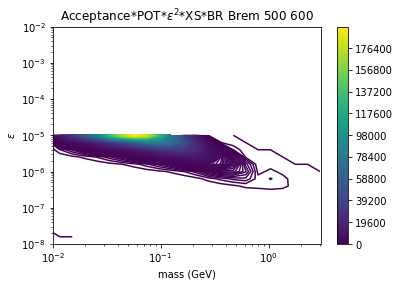

<Figure size 432x288 with 0 Axes>

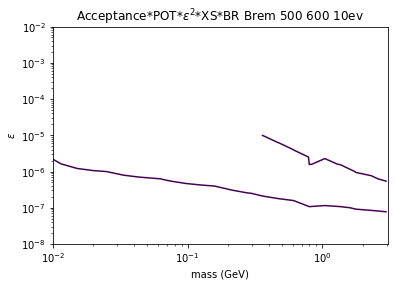

<Figure size 432x288 with 0 Axes>

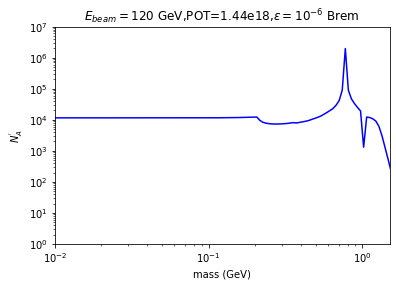

<Figure size 432x288 with 0 Axes>

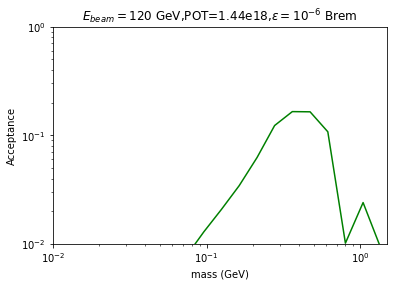

<Figure size 432x288 with 0 Axes>

In [5]:
yields(500,600,"electrons","Brem")

### Eta production mode

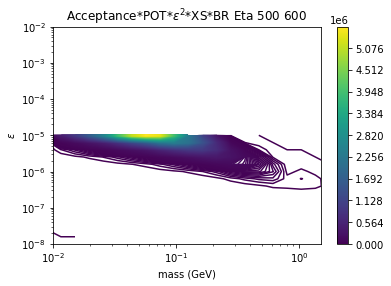

<Figure size 432x288 with 0 Axes>

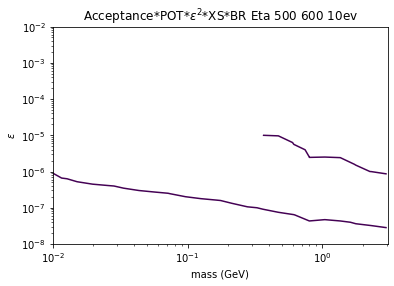

<Figure size 432x288 with 0 Axes>

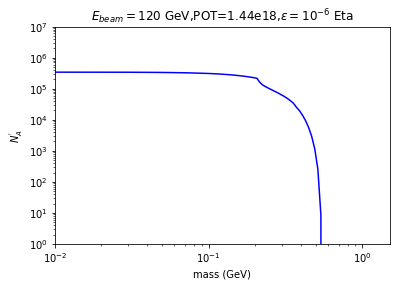

<Figure size 432x288 with 0 Axes>

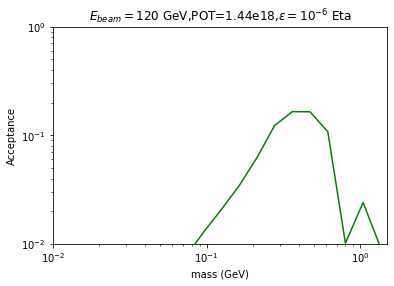

<Figure size 432x288 with 0 Axes>

In [6]:
yields(500,600,"electrons","Eta")

For muons:

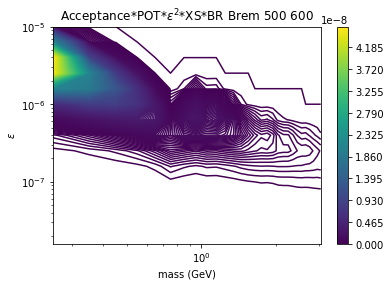

/Users/cristina/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:71: UserWarning: No contour levels were found within the data range.


<Figure size 432x288 with 0 Axes>

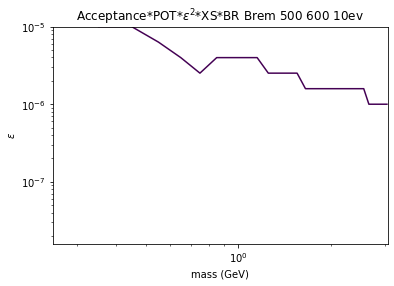

<Figure size 432x288 with 0 Axes>

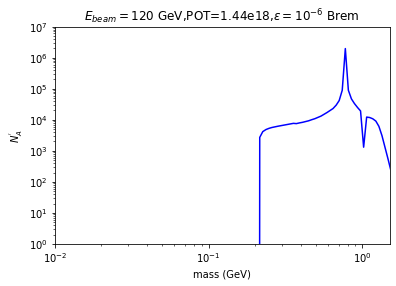

<Figure size 432x288 with 0 Axes>

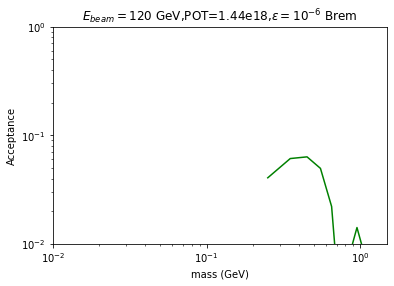

<Figure size 432x288 with 0 Axes>

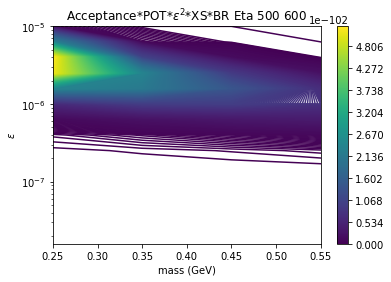

<Figure size 432x288 with 0 Axes>

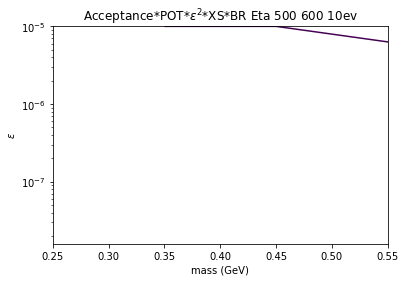

<Figure size 432x288 with 0 Axes>

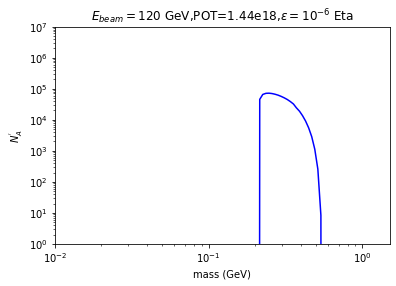

<Figure size 432x288 with 0 Axes>

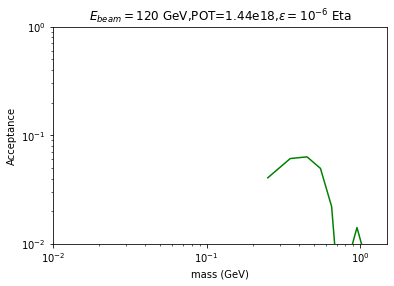

<Figure size 432x288 with 0 Axes>

In [7]:
yields(500,600,"muons","Brem")
yields(500,600,"muons","Eta")

In [ ]:
# test function to add elements to ordered dict
from collections import OrderedDict 

rates = OrderedDict()
rates = {'1': 0,
         '3': 1,
         '4': 2,
        }
masses = [1,2,3,4,5,6]

im = 0
lrates = list(rates.values())
print(list(rates.keys()))
print(lrates)
new_rates = {}
for m in masses:
    mass = str(m)
    if mass in list(rates.keys()):
        im = im + 1
        new_rates[mass] = rates[mass]
        print('here',new_rates[mass])
    else:
        print(im)
        new_rates[m] = lrates[im-1]

In [ ]:
# plot from file
bfs = {}
iBFfile = "data/BFtoElectrons.txt"
iBR = open(iBFfile)
for l in iBR:
    temp = l.split()
    if '#' in l or len(temp)==0: continue
    mass = pow(10,float(temp[0]))
    bfs['%.3f'%mass] = pow(10,float(temp[1]))
    
rates_file = OrderedDict() 
ifileYield = open("data/BremYield.txt")
for l in ifileYield:
    temp = l.split()
    if '#' in l or len(temp)==0: continue
    column2 = 10**(float(temp[1]))
    mass = pow(10,float(temp[0]))
    rates_file['%.3f'%mass] = pow(10,float(temp[1]))*bfs['%.3f'%mass]

masses = [float(i) for i in rates_file.keys()]
yields = list(rates_file.values())
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title(r'Yields')
ax.set_yscale('log')
ax.plot(masses,yields,color='green')
ax.set_xscale('log')
ax.set_xticks([0.1,1,1.5])
plt.show()
plt.clf()

In [ ]:
rates = OrderedDict() 
ifile = open("data/AprimeToMuonsRate_Brem.txt")
for l in ifile:
    temp = l.split()
    if 'GeV' in l: continue
    rates['%.3f'%float(temp[0])] = float(temp[1])
    
masses = [float(i) for i in rates.keys()]
yields = list(rates.values())
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title(r'Yields')
ax.set_yscale('log')
ax.plot(masses,yields,color='green')
ax.set_xscale('log')
ax.set_xlim(0.01,1)
ax.set_xticks([0.1,1,1.5])
plt.show()
plt.clf()